<a href="https://colab.research.google.com/github/kr1347/ResNet-Model/blob/main/ResNet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split


In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

zip_path = '/content/drive/My Drive/UTK_Dataset.zip'

# Path where you want to extract the contents of the zip file
extract_to_path = '/content/dataset'

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

# List the folders in the extracted directory
extracted_folders = [f for f in os.listdir(extract_to_path) if os.path.isdir(os.path.join(extract_to_path, f))]
print("Extracted folders:", extracted_folders)

Extracted folders: ['utkface_aligned_cropped', 'UTKFace', 'crop_part1']


In [ ]:
specific_folder_name = '/content/drive/My Drive/UTK_Dataset.zip'  # You can set this based on your logic
full_path_to_folder = os.path.join(extract_to_path, specific_folder_name)

# Optionally, move the selected folder to a new path (if needed)
data_dir = '/content/new_dataset_path'
os.rename(full_path_to_folder, os.path.join(data_dir, specific_folder_name))

# Print the final path to verify it's correct
print("New path to the specific folder for dataset processing:", os.path.join(data_dir, specific_folder_name))

New path to the specific folder for dataset processing: /content/drive/My Drive/UTK_Dataset.zip


In [ ]:
def get_utkface_data(data_dir):
    image_paths = []
    ages = []

    for filename in os.listdir(data_dir):
        if filename.endswith('.jpg'):
            try:
                age = int(filename.split('_')[0])
                image_paths.append(os.path.join(data_dir, filename))
                ages.append(age)
            except:
                continue  # skip invalid file names

    return image_paths, ages


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
class UTKFaceDataset(Dataset):
    def __init__(self, image_paths, age_labels, transform=None):
        self.image_paths = image_paths
        self.age_labels = age_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        age = float(self.age_labels[idx])
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(age, dtype=torch.float32)


In [ ]:
from sklearn.model_selection import train_test_split
data_dir = '/content/dataset/UTKFace'
image_paths, age_labels = get_utkface_data(data_dir)



train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, age_labels, test_size=0.2, random_state=42
)



In [ ]:
import os

def get_utkface_data(data_dir):
    image_paths = []
    age_labels = []

    for filename in os.listdir(data_dir):
        if filename.endswith('.jpg'):
            try:
                age = int(filename.split('_')[0])
                full_path = os.path.join(data_dir, filename)
                image_paths.append(full_path)
                age_labels.append(age)
            except ValueError:
                continue

    return image_paths, age_labels

image_paths, age_labels = get_utkface_data(data_dir)
print(f"Loaded {len(image_paths)} images.")


Loaded 23708 images.


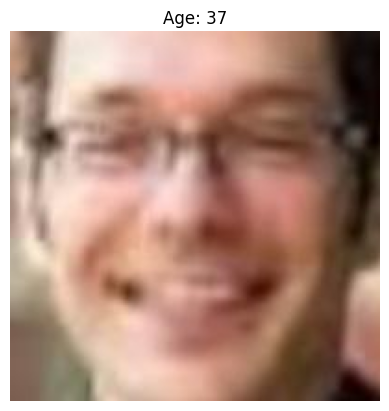

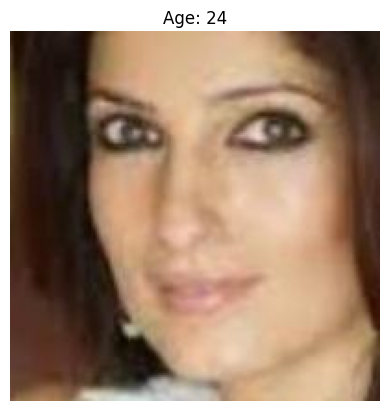

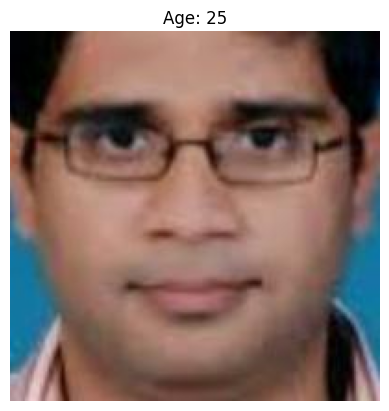

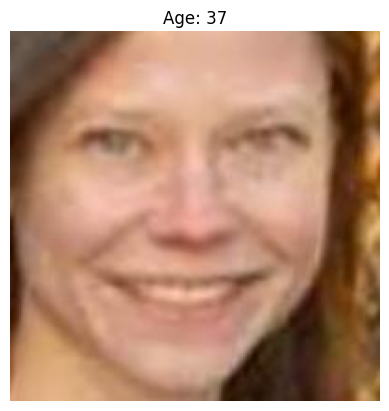

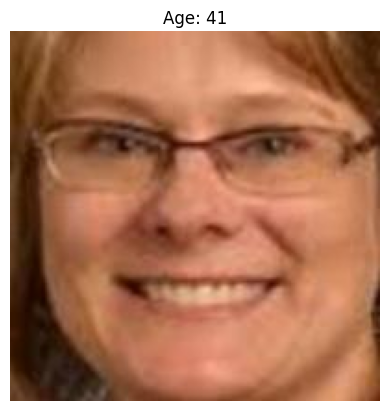

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt


for i in range(5):
    img = Image.open(image_paths[i])
    age = age_labels[i]
    plt.imshow(img)
    plt.title(f"Age: {age}")
    plt.axis("off")
    plt.show()


In [ ]:


from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
from PIL import Image


train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class UTKFaceDataset(Dataset):
    def __init__(self, image_paths, age_labels, transform=None):
        self.image_paths = image_paths
        self.age_labels = age_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        age = float(self.age_labels[idx])
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(age, dtype=torch.float32)


dataset = UTKFaceDataset(image_paths, age_labels, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [ ]:

for batch_images, batch_ages in loader:
    print(f"Image batch shape: {batch_images.shape}")
    print(f"Age batch: {batch_ages[:5]}")
    break


Image batch shape: torch.Size([32, 3, 224, 224])
Age batch: tensor([ 3., 26., 78., 24., 37.])


#Define ResNet-50 Age Regression Model

In [ ]:
import torch.nn as nn
from torchvision import models

class AgeRegressionResNet(nn.Module):
    def __init__(self):
        super(AgeRegressionResNet, self).__init__()
        self.base_model = models.resnet50(pretrained=True)
        self.base_model.fc = nn.Sequential(
            nn.Linear(self.base_model.fc.in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.base_model(x)


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AgeRegressionResNet().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from tqdm import tqdm
import numpy as np

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0


        for images, ages in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]"):
            images = images.to(device)
            ages = ages.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, ages)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * images.size(0)

        avg_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)


        model.eval()
        running_val_loss = 0.0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for images, ages in val_loader:
                images = images.to(device)
                ages = ages.to(device).unsqueeze(1)

                outputs = model(images)
                loss = criterion(outputs, ages)
                running_val_loss += loss.item() * images.size(0)

                all_preds.extend(outputs.cpu().numpy().flatten())
                all_targets.extend(ages.cpu().numpy().flatten())

        avg_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)


        all_preds = np.array(all_preds)
        all_targets = np.array(all_targets)


        mae = np.mean(np.abs(all_preds - all_targets))


        acc_3 = np.mean(np.abs(all_preds - all_targets) <= 3) * 100
        acc_5 = np.mean(np.abs(all_preds - all_targets) <= 5) * 100
        acc_10 = np.mean(np.abs(all_preds - all_targets) <= 10) * 100

        print(f"Epoch {epoch+1}/{epochs} --> "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, "
              f"MAE: {mae:.2f}, "
              f"Acc@±3yrs: {acc_3:.2f}%, "
              f"Acc@±5yrs: {acc_5:.2f}%, "
              f"Acc@±10yrs: {acc_10:.2f}%")

    return train_losses, val_losses


In [ ]:



from torch.utils.data import DataLoader


train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset = UTKFaceDataset(train_paths, train_labels, transform=train_transform)
test_dataset = UTKFaceDataset(test_paths, test_labels, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=30)


Epoch 1/30 [Training]: 100%|██████████| 593/593 [01:59<00:00,  4.97it/s]


Epoch 1/30 --> Train Loss: 225.4602, Val Loss: 93.8175, MAE: 7.18, Acc@±3yrs: 29.58%, Acc@±5yrs: 47.27%, Acc@±10yrs: 75.85%


Epoch 2/30 [Training]: 100%|██████████| 593/593 [01:59<00:00,  4.96it/s]


Epoch 2/30 --> Train Loss: 133.0075, Val Loss: 72.6890, MAE: 6.24, Acc@±3yrs: 35.61%, Acc@±5yrs: 53.06%, Acc@±10yrs: 79.78%


Epoch 3/30 [Training]: 100%|██████████| 593/593 [01:59<00:00,  4.97it/s]


Epoch 3/30 --> Train Loss: 121.3289, Val Loss: 70.2524, MAE: 6.19, Acc@±3yrs: 35.96%, Acc@±5yrs: 52.82%, Acc@±10yrs: 80.19%


Epoch 4/30 [Training]: 100%|██████████| 593/593 [01:59<00:00,  4.97it/s]


Epoch 4/30 --> Train Loss: 114.5145, Val Loss: 61.0828, MAE: 5.75, Acc@±3yrs: 37.44%, Acc@±5yrs: 55.79%, Acc@±10yrs: 83.12%


Epoch 5/30 [Training]: 100%|██████████| 593/593 [01:59<00:00,  4.97it/s]


Epoch 5/30 --> Train Loss: 109.7107, Val Loss: 70.5498, MAE: 6.06, Acc@±3yrs: 37.17%, Acc@±5yrs: 54.77%, Acc@±10yrs: 81.15%


Epoch 6/30 [Training]: 100%|██████████| 593/593 [01:59<00:00,  4.98it/s]


Epoch 6/30 --> Train Loss: 103.6676, Val Loss: 58.2789, MAE: 5.46, Acc@±3yrs: 41.25%, Acc@±5yrs: 60.04%, Acc@±10yrs: 84.09%


Epoch 7/30 [Training]: 100%|██████████| 593/593 [01:59<00:00,  4.98it/s]


Epoch 7/30 --> Train Loss: 101.7404, Val Loss: 75.3930, MAE: 6.20, Acc@±3yrs: 37.83%, Acc@±5yrs: 53.79%, Acc@±10yrs: 79.35%


Epoch 8/30 [Training]: 100%|██████████| 593/593 [01:59<00:00,  4.97it/s]


Epoch 8/30 --> Train Loss: 98.7315, Val Loss: 53.2448, MAE: 5.28, Acc@±3yrs: 41.40%, Acc@±5yrs: 59.65%, Acc@±10yrs: 85.58%


Epoch 9/30 [Training]: 100%|██████████| 593/593 [01:58<00:00,  4.98it/s]


Epoch 9/30 --> Train Loss: 94.7795, Val Loss: 54.0995, MAE: 5.31, Acc@±3yrs: 40.85%, Acc@±5yrs: 59.81%, Acc@±10yrs: 85.55%


Epoch 10/30 [Training]: 100%|██████████| 593/593 [01:58<00:00,  4.99it/s]


Epoch 10/30 --> Train Loss: 96.7022, Val Loss: 52.7249, MAE: 5.14, Acc@±3yrs: 43.86%, Acc@±5yrs: 62.45%, Acc@±10yrs: 85.53%


Epoch 11/30 [Training]: 100%|██████████| 593/593 [01:59<00:00,  4.97it/s]


Epoch 11/30 --> Train Loss: 90.5862, Val Loss: 53.2240, MAE: 5.36, Acc@±3yrs: 38.84%, Acc@±5yrs: 59.64%, Acc@±10yrs: 85.49%


Epoch 12/30 [Training]: 100%|██████████| 593/593 [01:59<00:00,  4.97it/s]


Epoch 12/30 --> Train Loss: 88.5748, Val Loss: 48.9803, MAE: 4.94, Acc@±3yrs: 45.24%, Acc@±5yrs: 63.52%, Acc@±10yrs: 86.86%


Epoch 13/30 [Training]: 100%|██████████| 593/593 [01:59<00:00,  4.97it/s]


Epoch 13/30 --> Train Loss: 86.4732, Val Loss: 44.9588, MAE: 4.80, Acc@±3yrs: 44.76%, Acc@±5yrs: 63.05%, Acc@±10yrs: 88.46%


Epoch 14/30 [Training]: 100%|██████████| 593/593 [01:59<00:00,  4.98it/s]


Epoch 14/30 --> Train Loss: 84.7088, Val Loss: 48.4479, MAE: 5.00, Acc@±3yrs: 42.58%, Acc@±5yrs: 62.27%, Acc@±10yrs: 87.87%


Epoch 15/30 [Training]: 100%|██████████| 593/593 [01:59<00:00,  4.97it/s]


Epoch 15/30 --> Train Loss: 83.6296, Val Loss: 41.7429, MAE: 4.63, Acc@±3yrs: 45.76%, Acc@±5yrs: 64.82%, Acc@±10yrs: 89.05%


Epoch 16/30 [Training]: 100%|██████████| 593/593 [01:59<00:00,  4.98it/s]


Epoch 16/30 --> Train Loss: 81.7856, Val Loss: 43.3625, MAE: 4.79, Acc@±3yrs: 43.95%, Acc@±5yrs: 63.17%, Acc@±10yrs: 88.39%


Epoch 17/30 [Training]: 100%|██████████| 593/593 [01:59<00:00,  4.98it/s]


Epoch 17/30 --> Train Loss: 80.2203, Val Loss: 52.0539, MAE: 5.12, Acc@±3yrs: 43.93%, Acc@±5yrs: 61.77%, Acc@±10yrs: 85.38%


Epoch 18/30 [Training]: 100%|██████████| 593/593 [01:59<00:00,  4.96it/s]


Epoch 18/30 --> Train Loss: 80.0888, Val Loss: 45.9983, MAE: 4.83, Acc@±3yrs: 45.20%, Acc@±5yrs: 64.18%, Acc@±10yrs: 87.84%


Epoch 19/30 [Training]: 100%|██████████| 593/593 [01:59<00:00,  4.98it/s]


Epoch 19/30 --> Train Loss: 77.5949, Val Loss: 44.0154, MAE: 4.73, Acc@±3yrs: 45.87%, Acc@±5yrs: 65.60%, Acc@±10yrs: 88.30%


Epoch 20/30 [Training]: 100%|██████████| 593/593 [01:59<00:00,  4.95it/s]


Epoch 20/30 --> Train Loss: 78.5066, Val Loss: 44.2116, MAE: 4.77, Acc@±3yrs: 44.90%, Acc@±5yrs: 63.81%, Acc@±10yrs: 88.53%


Epoch 21/30 [Training]: 100%|██████████| 593/593 [01:59<00:00,  4.98it/s]


Epoch 21/30 --> Train Loss: 78.1983, Val Loss: 41.2596, MAE: 4.59, Acc@±3yrs: 46.31%, Acc@±5yrs: 65.43%, Acc@±10yrs: 89.40%


Epoch 22/30 [Training]: 100%|██████████| 593/593 [01:59<00:00,  4.96it/s]


Epoch 22/30 --> Train Loss: 76.2393, Val Loss: 42.2548, MAE: 4.68, Acc@±3yrs: 46.06%, Acc@±5yrs: 64.61%, Acc@±10yrs: 88.70%


Epoch 23/30 [Training]: 100%|██████████| 593/593 [01:59<00:00,  4.98it/s]


Epoch 23/30 --> Train Loss: 74.3551, Val Loss: 39.3628, MAE: 4.47, Acc@±3yrs: 47.20%, Acc@±5yrs: 66.58%, Acc@±10yrs: 90.37%


Epoch 24/30 [Training]: 100%|██████████| 593/593 [01:58<00:00,  4.98it/s]


Epoch 24/30 --> Train Loss: 72.5115, Val Loss: 45.8235, MAE: 4.76, Acc@±3yrs: 46.83%, Acc@±5yrs: 64.23%, Acc@±10yrs: 87.83%


Epoch 25/30 [Training]: 100%|██████████| 593/593 [01:59<00:00,  4.97it/s]


Epoch 25/30 --> Train Loss: 73.8386, Val Loss: 38.9176, MAE: 4.44, Acc@±3yrs: 47.12%, Acc@±5yrs: 66.74%, Acc@±10yrs: 90.88%


Epoch 26/30 [Training]: 100%|██████████| 593/593 [01:58<00:00,  4.99it/s]


Epoch 26/30 --> Train Loss: 71.9791, Val Loss: 42.1030, MAE: 4.70, Acc@±3yrs: 44.34%, Acc@±5yrs: 63.70%, Acc@±10yrs: 88.77%


Epoch 27/30 [Training]: 100%|██████████| 593/593 [01:58<00:00,  4.99it/s]


Epoch 27/30 --> Train Loss: 71.6540, Val Loss: 39.3828, MAE: 4.40, Acc@±3yrs: 49.02%, Acc@±5yrs: 66.89%, Acc@±10yrs: 90.14%


Epoch 28/30 [Training]: 100%|██████████| 593/593 [01:59<00:00,  4.96it/s]


Epoch 28/30 --> Train Loss: 71.5573, Val Loss: 37.5251, MAE: 4.30, Acc@±3yrs: 49.60%, Acc@±5yrs: 68.19%, Acc@±10yrs: 90.38%


Epoch 29/30 [Training]: 100%|██████████| 593/593 [01:59<00:00,  4.97it/s]


Epoch 29/30 --> Train Loss: 71.8186, Val Loss: 37.8881, MAE: 4.39, Acc@±3yrs: 47.14%, Acc@±5yrs: 66.57%, Acc@±10yrs: 90.82%


Epoch 30/30 [Training]: 100%|██████████| 593/593 [01:59<00:00,  4.98it/s]


Epoch 30/30 --> Train Loss: 67.8511, Val Loss: 39.0376, MAE: 4.50, Acc@±3yrs: 45.21%, Acc@±5yrs: 66.40%, Acc@±10yrs: 90.48%


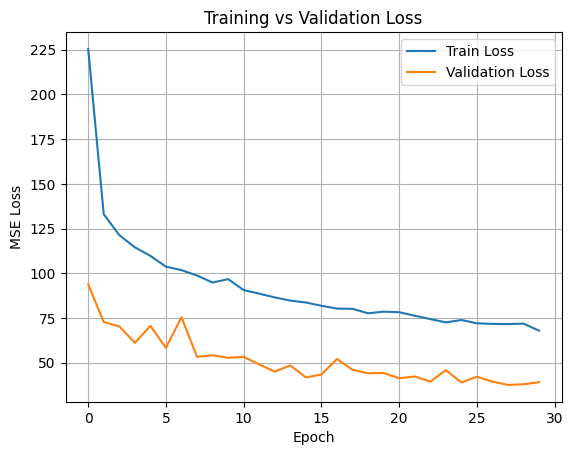

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Split dataset
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
from tqdm import tqdm
import numpy as np

def train_model(model, train_loader, criterion, optimizer, epochs=10):
    train_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        all_preds = []
        all_targets = []

        for images, ages in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]"):
            images = images.to(device)
            ages = ages.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, ages)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            all_preds.extend(outputs.detach().cpu().numpy().flatten())
            all_targets.extend(ages.cpu().numpy().flatten())

        avg_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)


        all_preds = np.array(all_preds)
        all_targets = np.array(all_targets)

        acc_3 = np.mean(np.abs(all_preds - all_targets) <= 3) * 100
        acc_5 = np.mean(np.abs(all_preds - all_targets) <= 5) * 100
        acc_10 = np.mean(np.abs(all_preds - all_targets) <= 10) * 100
        avg_acc = (acc_3 + acc_5 + acc_10) / 3


        print(f"Epoch {epoch+1}/{epochs} --> "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Acc@±3: {acc_3:.2f}%, "
              f"Acc@±5: {acc_5:.2f}%, "
              f"Acc@±10: {acc_10:.2f}%, "
              f"Avg Acc: {avg_acc:.2f}%")

    return train_losses


In [ ]:
def test_model(model, test_loader):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, ages in test_loader:
            images = images.to(device)
            ages = ages.to(device).unsqueeze(1)

            outputs = model(images)
            all_preds.extend(outputs.cpu().numpy().flatten())
            all_targets.extend(ages.cpu().numpy().flatten())

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)


    mae = np.mean(np.abs(all_preds - all_targets))
    rmse = np.sqrt(np.mean((all_preds - all_targets) ** 2))
    acc_3 = np.mean(np.abs(all_preds - all_targets) <= 3) * 100
    acc_5 = np.mean(np.abs(all_preds - all_targets) <= 5) * 100
    acc_10 = np.mean(np.abs(all_preds - all_targets) <= 10) * 100
    avg_acc = (acc_3 + acc_5 + acc_10) / 3

    print(f"\n Test Results:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"Accuracy (±3 yrs): {acc_3:.2f}%")
    print(f"Accuracy (±5 yrs): {acc_5:.2f}%")
    print(f"Accuracy (±10 yrs): {acc_10:.2f}%")
    print(f"Average Accuracy: {avg_acc:.2f}%")

    return all_preds, all_targets


In [ ]:
# Train
train_losses = train_model(model, train_loader, criterion, optimizer, epochs=10)

# Test
predictions, ground_truth = test_model(model, test_loader)


Epoch 1/10 [Training]: 100%|██████████| 593/593 [01:59<00:00,  4.98it/s]


Epoch 1/10 --> Train Loss: 67.2302, Acc@±3: 39.58%, Acc@±5: 56.96%, Acc@±10: 82.12%, Avg Acc: 59.55%


Epoch 2/10 [Training]: 100%|██████████| 593/593 [01:58<00:00,  4.99it/s]


Epoch 2/10 --> Train Loss: 69.3167, Acc@±3: 39.42%, Acc@±5: 57.31%, Acc@±10: 82.45%, Avg Acc: 59.73%


Epoch 3/10 [Training]: 100%|██████████| 593/593 [01:59<00:00,  4.98it/s]


Epoch 3/10 --> Train Loss: 70.1992, Acc@±3: 38.68%, Acc@±5: 56.34%, Acc@±10: 82.02%, Avg Acc: 59.01%


Epoch 4/10 [Training]: 100%|██████████| 593/593 [01:59<00:00,  4.97it/s]


Epoch 4/10 --> Train Loss: 64.4824, Acc@±3: 39.73%, Acc@±5: 57.33%, Acc@±10: 83.44%, Avg Acc: 60.17%


Epoch 5/10 [Training]: 100%|██████████| 593/593 [01:59<00:00,  4.98it/s]


Epoch 5/10 --> Train Loss: 64.4806, Acc@±3: 39.51%, Acc@±5: 57.04%, Acc@±10: 83.07%, Avg Acc: 59.87%


Epoch 6/10 [Training]: 100%|██████████| 593/593 [01:59<00:00,  4.97it/s]


Epoch 6/10 --> Train Loss: 63.5151, Acc@±3: 39.81%, Acc@±5: 57.40%, Acc@±10: 83.25%, Avg Acc: 60.15%


Epoch 7/10 [Training]: 100%|██████████| 593/593 [01:59<00:00,  4.98it/s]


Epoch 7/10 --> Train Loss: 62.9341, Acc@±3: 40.04%, Acc@±5: 58.34%, Acc@±10: 83.63%, Avg Acc: 60.67%


Epoch 8/10 [Training]: 100%|██████████| 593/593 [01:58<00:00,  4.99it/s]


Epoch 8/10 --> Train Loss: 63.4761, Acc@±3: 40.56%, Acc@±5: 58.21%, Acc@±10: 83.54%, Avg Acc: 60.77%


Epoch 9/10 [Training]: 100%|██████████| 593/593 [01:58<00:00,  5.00it/s]


Epoch 9/10 --> Train Loss: 61.4593, Acc@±3: 40.64%, Acc@±5: 58.79%, Acc@±10: 83.75%, Avg Acc: 61.06%


Epoch 10/10 [Training]: 100%|██████████| 593/593 [01:58<00:00,  5.00it/s]


Epoch 10/10 --> Train Loss: 64.3735, Acc@±3: 40.43%, Acc@±5: 58.31%, Acc@±10: 83.61%, Avg Acc: 60.78%

 Test Results:
MAE: 5.07
RMSE: 7.19
Accuracy (±3 yrs): 43.46%
Accuracy (±5 yrs): 61.77%
Accuracy (±10 yrs): 85.83%
Average Accuracy: 63.69%


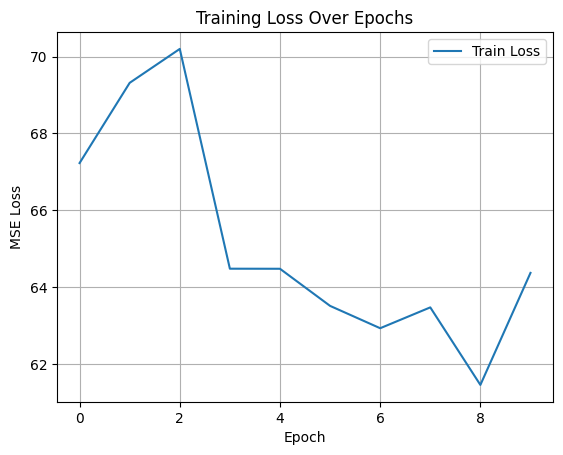

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
torch.save(model.state_dict(), "age_regression_resnet50.pt")


In [ ]:
!pip install face_recognition


In [ ]:
model = AgeRegressionResNet().to(device)
model.load_state_dict(torch.load("/content/age_regression_resnet50.pt"))
model.eval()


AgeRegressionResNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequent

In [ ]:
from google.colab import files
uploaded = files.upload()

# Grab the filename
uploaded_file = next(iter(uploaded))
print(f" Uploaded file: {uploaded_file}")


In [ ]:
import face_recognition
import numpy as np
from PIL import Image

def crop_face(image_path):

    pil_image = Image.open(image_path).convert("RGB")
    image = np.array(pil_image)


    face_locations = face_recognition.face_locations(image)

    if len(face_locations) == 0:
        raise ValueError(" No face detected in the image.")

    top, right, bottom, left = face_locations[0]
    face_image = image[top:bottom, left:right]
    return Image.fromarray(face_image)


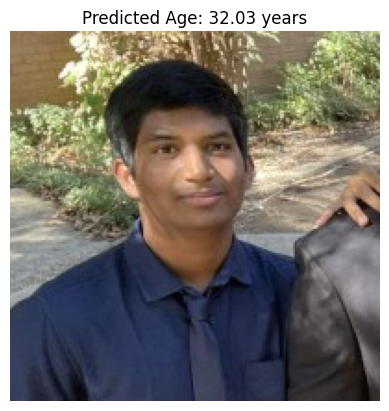

In [ ]:
plt.imshow(image)
plt.title(f"Predicted Age: {predicted_age:.2f} years")
plt.axis('off')
plt.show()
